In [1]:
!pip install numpy pandas matplotlib --no-index

Ignoring indexes: https://pypi.python.org/simple


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import time
%matplotlib inline

# Function to read data - Fonction pour lire les données
Our logs are compressed in the gzip format. Once uncompressed, there are 1.1GB worth of logs. They are in a "key=value" format, where pairs of key-value are separated by spaces. It is also possible that some keys do not exist for some lines. We must therefore write a function to read this format and create a DataFrame out of it. There are also many columns that we don't need, which we will delete. 

The cell below shows an example of logs

---
Les données sont dans un fichier compressé. Une fois décompressé, il y a environ 1.1Go de logs. Les logs sont dans un format "clé=valeur" où les paires de clé-valeur sont séparées par des espaces. Il est possible que certaines clés n'existent pas pour certaines lignes. Il faut donc lire ces données et en faire un DataFrame. Il y a aussi plusieurs colonnes dont nous n'avons pas besoin. Pour sauver de la mémoire, nous les supprimons. 

La cellule ci-dessous montre un exemple de ligne de log. 

In [3]:
! zcat ../colosse_logs_2.txt.gz | head -n 1

user=laurent group=cvt-445-01 account=cvt-445-ac jobname=array queue=maint ctime=1352311469 qtime=1352311469 etime=1352311469 start=1352311470 owner=laurent@moab.colosse.clumeq.ca exec_host=r101-n7/7+r101-n7/6+r101-n7/5+r101-n7/4+r101-n7/3+r101-n7/2+r101-n7/1+r101-n7/0 Resource_List.neednodes=1:ppn=8 Resource_List.nodect=1 Resource_List.nodes=1:ppn=8 Resource_List.walltime=00:02:10 session=8791 end=1352311594 Exit_status=0 resources_used.cput=00:00:00 resources_used.mem=2936kb resources_used.vmem=188840kb resources_used.walltime=00:02:04

gzip: stdout: Broken pipe


In [4]:
def read_kv_csv_logs(filename,csv_separator=' ',kv_separator='='):
    import gzip
    with gzip.open(filename, mode='rt') as infile:
        content = infile.readlines()
        content = [dict(kv.split(kv_separator,1) for kv in ls) for ls in (line.strip('\n').split(csv_separator) for line in content)]
    return pd.DataFrame(content)

columns_to_drop=['Error_Path','Exit_status','Output_Path',
                 'Resource_List.depend','Resource_List.epilogue','Resource_List.flags','Resource_List.dmem',
                 'Resource_List.host','Resource_List.naccesspolicy','Resource_List.pmem','Resource_List.procs',
                 'Resource_List.prologue','Resource_List.qos','Resource_List.hostlist','Resource_List.signal',
                 'Resource_List.tpn','Resource_List.gattr','Resource_List.advres','Resource_List.cput',
                 'Resource_List.ncpus','Resource_List.opsys','Resource_List.trig','Resource_List.neednodes']
def delete_useless_columns(indf,drop_columns=columns_to_drop):
    # try to delete useless columns
    for c in drop_columns:
        try:
            del indf[c]
        except:  # if there is an exception, it means the column does not exist
            pass


# Functions to calculate derivated data - Fonctions pour calculer des données dérivées
The original data are not necessarily in a format which is easily usable. For example, the list of resources is in the format "Resource_List.neednodes=1:ppn=8". This column contains two pieces of information: the job required one node, and 8 cores. In order to use this information, we must extract the various parts, put them in a numeric format to then use them. The functions below calculate the derivated data based on the original columns. 

---

Les données originales ne sont pas nécessairement dans un format qui est facilement utilisable. Par exemple, la liste des ressources est dans le format: "Resource_List.neednodes=1:ppn=8". Cette colonne contient deux informations: La tâche nécessitait 1 noeud, et 8 coeurs. Il faut pouvoir extraire ces informations et les mettre sous forme numérique afin de pouvoir les utiliser. Les fonctions ci-dessous permettent de calculer des données dérivées à partir des champs originaux. 

In [5]:
def regex_match(instr,regex):
    if type(instr) is str:
        m = re.search(regex,instr)
        if m:
            return int(m.group(1))
        else:
            return 0
    return instr

def node_count(instr):
    return regex_match(instr,'^([0-9][0-9]*)[^0-9]*')

def ppn(instr):
    return regex_match(instr,'.*ppn=([0-9][0-9]*)[^0-9]*')

def gpupn(instr):
    return regex_match(instr,'.*gpus=([0-9][0-9]*)[^0-9]*')

def walltime_to_seconds(instr):
    if type(instr) is str:
        data = instr.split(':')
        if len(data) == 1:
            return int(data[0])
        elif len(data) == 2:
            return int(data[0])*60 + int(data[1])
        elif len(data) == 3:
            return int(data[0])*3600 + int(data[1])*60 + int(data[2])
        elif len(data) == 4:
            return int(data[0])*3600*24 + int(data[1])*3600 + int(data[2])*60 + int(data[3])
    return instr

def duration(start,end,req_walltime):
    if type(start) is str and type(end) is str:
        try:
            start = int(start)
            end = int(end)
            # bugged entry
            if end - start > req_walltime*2:
                return None
            return end - start
        except:
            return None
    return None

def memory_str_to_memory_gb(instr):
    if type(instr) is str:
        numkb = regex_match(instr,'([0-9][0-9]*)[kK][bB]')
        if numkb > 0: return float(numkb)/1024/1024
        nummb = regex_match(instr,'([0-9][0-9]*)[mM][bB]')
        if nummb > 0: return float(nummb)/1024
        numgb = regex_match(instr,'([0-9][0-9]*)[gG][bB]')
        if numgb > 0: return numgb
        return 0

    return instr

# Calculating derivated data - Calcul des données dérivées
Using the functions above, we define multiple new fields, which will be calculated based on the original data. 

---
En utilisant les fonctions ci-dessus, nous définissons plusieurs nouveaux champs, qui seront calculés à partir des données originales. 

In [6]:
def compute_data(indf):
    indf["node_count"] = indf.apply(lambda row: node_count(row["Resource_List.nodes"]),axis=1)
    indf["ppn"] = indf.apply(lambda row: ppn(row["Resource_List.nodes"]),axis=1)
    indf["total_cores"] = indf.apply(lambda row: row["node_count"]*row["ppn"],axis=1)
    indf["gpupn"] = indf.apply(lambda row: gpupn(row["Resource_List.nodes"]),axis=1)
    indf["total_gpus"] = indf.apply(lambda row: row["node_count"]*row["gpupn"],axis=1)

    indf["req_walltime"] = indf.apply(lambda row: walltime_to_seconds(row["Resource_List.walltime"]),axis=1)
    indf["req_memory_gb"] = indf.apply(lambda row: memory_str_to_memory_gb(row["Resource_List.mem"]),axis=1)
    indf["req_cput"] = indf.apply(lambda row: row["req_walltime"]*row["total_cores"],axis=1)
      
    indf["used_memory_gb"] = indf.apply(lambda row: memory_str_to_memory_gb(row["resources_used.mem"]),axis=1)
    indf["used_walltime"] = indf.apply(lambda row: walltime_to_seconds(row["resources_used.walltime"]),axis=1)
    indf["used_cput"] = indf.apply(lambda row: walltime_to_seconds(row["resources_used.cput"]),axis=1)

    indf["used_walltime_hours"] = indf.apply(lambda row: row["used_walltime"]//3600, axis=1)
    indf["req_walltime_hours"] = indf.apply(lambda row: row["req_walltime"]//3600, axis=1)
    indf["walltime_accuracy"] = indf.apply(lambda row: row["used_walltime"]/row["req_walltime"] if row["req_walltime"]>0 else None, axis=1)
    indf["used_memory_gb_integer"] = indf.apply(lambda row: int(row["used_memory_gb"]) if row["used_memory_gb"] > 0 else None,axis=1)
    indf["effective_cores"] = indf.apply(lambda row: float(row["used_cput"])/float(row["used_walltime"]) if row["used_walltime"] > 0 else None, axis=1)
    indf["used_memory_gb_per_eff_core"] = indf.apply(lambda row: row["used_memory_gb"]/float(row["effective_cores"]) if row["effective_cores"]>0 else None,axis=1)
    indf["used_memory_gb_per_req_core"] = indf.apply(lambda row: row["used_memory_gb"]/float(row["total_cores"]) if row["total_cores"]>0 else None,axis=1)
    indf["efficiency"] = indf.apply(lambda row: float(row["effective_cores"])/float(row["total_cores"]) if row["total_cores"] > 0 else None, axis=1)
    
    indf["dedicated_core_seconds"] = indf.apply(lambda row: row["used_walltime"]*row["total_cores"],axis=1)
    indf["dedicated_gpu_seconds"] = indf.apply(lambda row: row["used_walltime"]*row["total_gpus"],axis=1)
    
    return indf

# Function to create a plot - Fonction pour créer un graphique
We are usually interested to answer the following question: "What percentage of the workload requires X amount of resources ?"

To answer this question, we plot histograms for which the weight of each bin is given by the number of core-seconds of the job. We show both the regular histogram and the integrated (or cumulative) histogram. The regular histogram answers the question "What percentage of the workload requires exactly X amount of resources ?" while the cummulative histogram answers the question "What percentage of the workload requires X or less resources ?". 

--- 
Nous sommes généralement intéressés répondre à la question suivante: "Quel pourcentage du temps de calcul nécessite X ressources ?"

Pour ce faire, nous traçons des histogrammes dont le poids des barres est donné par le nombre de coeurs-secondes de la tâche. Nous affichons à la fois l'histogramme régulier et l'histogramme intégré (ou cumulatif). L'histogramme régulier répond à la question "Quel pourcentage du temps de calcul nécessite X ressources ?", alors que l'histogramme cumulatif répond à la question "Quel pourcentage du temps de calcul nécessite X ressources ou moins ?" 

In [7]:
def plot_percentage_usage(indf,col,bins=100,range=None,
                          weight_column="dedicated_core_seconds",
                          xlabel=None,ylabel=None,cumulative=True,normed=True,
                          quantile=None,
                         title="",
                         filter=None):    
    if filter is not None:
        toplot = indf[indf[col].notnull() & indf[weight_column].notnull() & filter]
    else:
        toplot = indf[indf[col].notnull() & indf[weight_column].notnull()]
        
    if range == None:
        if quantile:
            range = (0, toplot[col].quantile(quantile))
        else:
            range = (0, toplot[col].max())

    fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True)
    fig.tight_layout()
    
    if title:
        axes[0].set_title(title)


    axes[1].hist(toplot[col],
        weights=toplot[weight_column].values,
        bins=bins,
        range=range,
        cumulative=True,
        normed=normed
        )

    if xlabel:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(col)

    if ylabel:
        axes[1].set_ylabel(ylabel)
    else:
        axes[1].set_ylabel("Integrated \n" + weight_column + "\n (normalized)")
    
    axes[0].hist(toplot[col],
        weights=toplot[weight_column].values,
        bins=bins,
        range=range,
        cumulative=False,
        normed=normed
        )
    if ylabel:
        axes[0].set_ylabel(ylabel)
    else:
        axes[0].set_ylabel(weight_column + "\n (arbitrary units)")

        
    plt.savefig(title + "_" + col + ".png",bbox_inches='tight')
    plt.show()

# Reading and calculating data - Lecture et calcul des données

In [8]:
start = time.time()
colosse_df = read_kv_csv_logs("../colosse_logs_2.txt.gz")
delete_useless_columns(colosse_df)
print("Reading data:" + str(time.time() - start) + " seconds")

colosse_df_copy = colosse_df.copy()
start = time.time()
calculated_data_colosse = compute_data(colosse_df_copy)
print("Computing derivated data took:" + str(time.time()-start))

Reading data:82.06282663345337 seconds
Computing derivated data took:1120.1260974407196


# Plotting histograms - Génération des histogrammes

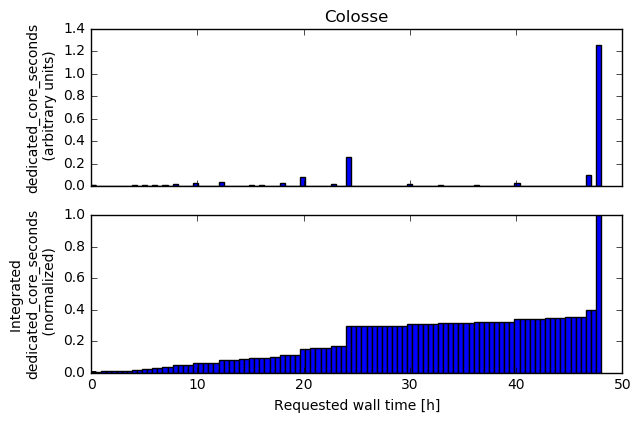

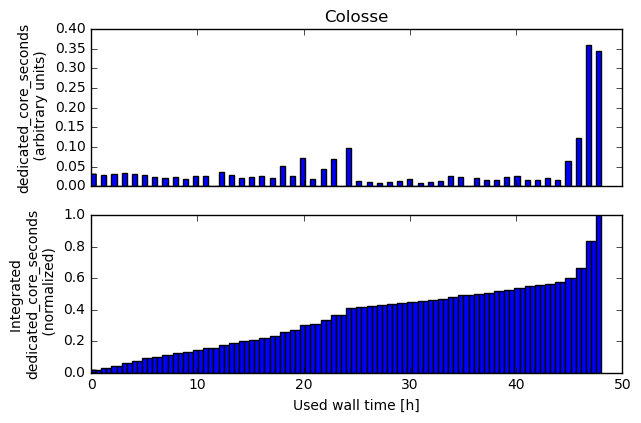

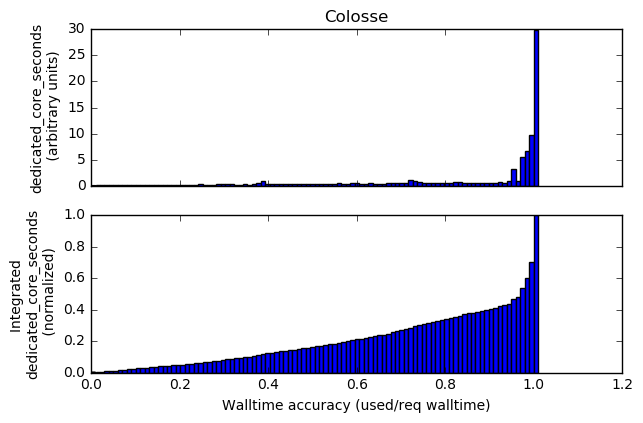

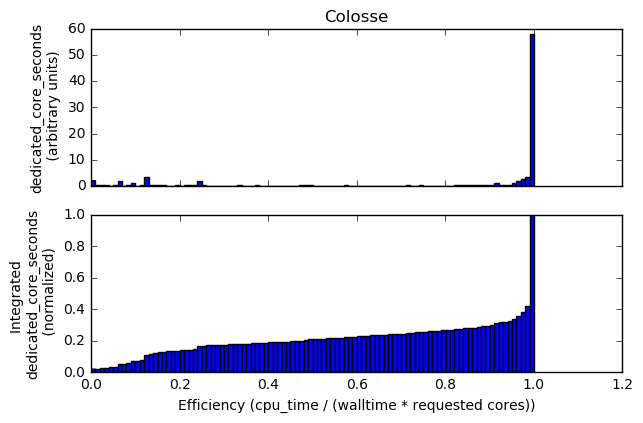

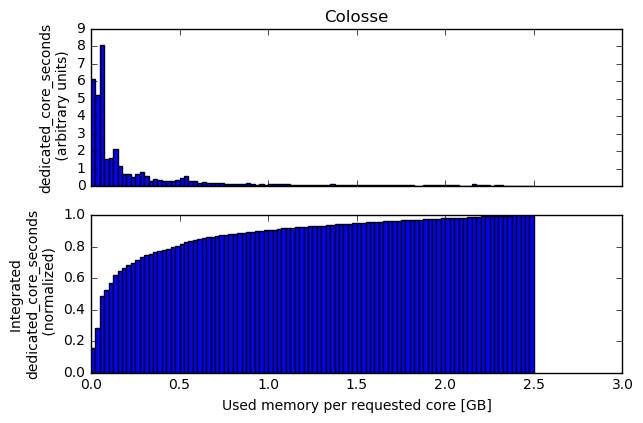

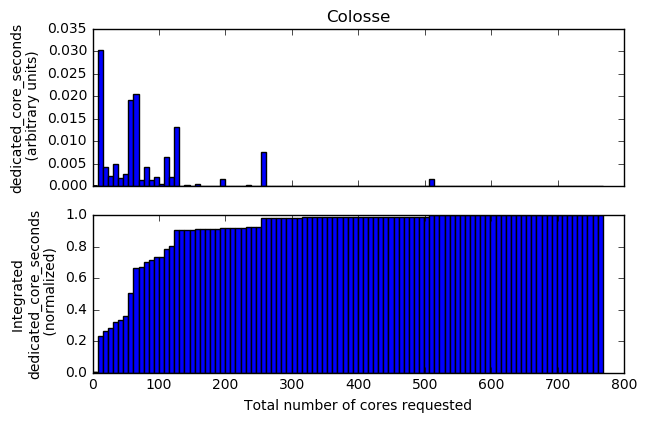

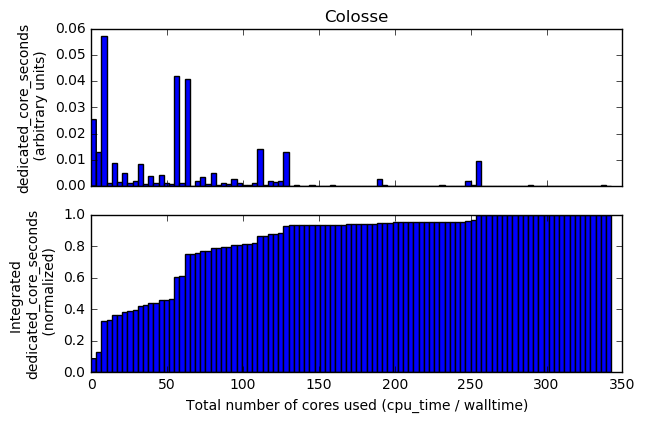

Generating histograms took:23.766221046447754


In [9]:
def interesting_plots(indf,title="",weight_column="dedicated_core_seconds",cumulative=True):
    plot_percentage_usage(indf,"req_walltime_hours",quantile=0.999, xlabel="Requested wall time [h]",title=title,weight_column=weight_column,cumulative=cumulative)
    plot_percentage_usage(indf,"used_walltime_hours",quantile=0.999, xlabel="Used wall time [h]",title=title,weight_column=weight_column,cumulative=cumulative)
    plot_percentage_usage(indf,"walltime_accuracy",quantile=0.99, xlabel="Walltime accuracy (used/req walltime)",title=title,weight_column=weight_column,cumulative=cumulative)
    plot_percentage_usage(indf,"efficiency",quantile=0.999, xlabel="Efficiency (cpu_time / (walltime * requested cores))",title=title,weight_column=weight_column,cumulative=cumulative)
    plot_percentage_usage(indf,"used_memory_gb_per_req_core",quantile=0.99, xlabel="Used memory per requested core [GB]",title=title,weight_column=weight_column,cumulative=cumulative)
    plot_percentage_usage(indf,"total_cores",quantile=0.999, xlabel="Total number of cores requested",title=title,weight_column=weight_column,cumulative=cumulative)
    plot_percentage_usage(indf,"effective_cores",quantile=0.999, xlabel="Total number of cores used (cpu_time / walltime)",title=title,weight_column=weight_column,cumulative=cumulative)

start = time.time()
interesting_plots(calculated_data_colosse,"Colosse")
print("Generating histograms took:" + str(time.time()-start))

# Performance conclusions - Conclusions relatives à la performance
With Pandas, it took 82 seconds to read the data, 20 minutes to compute the derivated data, and 23 seconds to generate the graphs. This was done on an 8 core machine with 24 GB of memory. However, given that Pandas is not parallelized, a single core was actually used to perform all calculation. This was for a 1.1 GB dataset. 

It is not so bad at this scale. However, if we now want to scale up our analysis, and do it for multiple, much larger clusters, we will run into a performance problem. This is where Spark will come in.

---
Avec Pandas, cela a pris 82 secondes pour lire les données, 20 minutes pour calculer les données dérivées, et 23 secondes pour générer les graphiques. Ceci a été fait sur un serveur à 8 coeurs de calcul avec 24 GB de mémoire. Néanmoins, Pandas n'étant pas parallèle, un seul coeur de calcul a été utilisé pour les calculs. Tout ceci a été fait pour un jeu de données de 1.1Go. 

Ce n'est pas si mal à cette échelle. Néanmoins, si nous voulons faire la même chose pour plusieurs grappes de calcul, avec des jeux de données beaucoup plus gros, nous allons avoir un problème de performance. C'est à ce point que nous nous tournerons vers Spark. 